In [1]:

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor



## Part A: Data Preprocessing and Baseline

In [2]:
# 2️⃣ Load Dataset
df = pd.read_csv("hour.csv")  
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

- No null values found.

In [5]:
# Drop irrelevant columns
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# Separate features and target
X = df.drop('cnt', axis=1)
y = df['cnt']

# Identify categorical and numerical columns
categorical_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# One-Hot Encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 13903
Testing samples: 3476


In [7]:
# Define K-Fold Cross Validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Custom RMSE scorer (since GridSearchCV minimizes loss)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [8]:
# ===============================================
# 🌳 Decision Tree Regressor with GridSearchCV
# ===============================================

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Hyperparameter grid
param_grid_dt = {
    'model__max_depth': [6],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Grid search with 5-fold CV
grid_dt = GridSearchCV(
    dt_pipeline,
    param_grid=param_grid_dt,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)

print("Best Parameters (Decision Tree):", grid_dt.best_params_)
print("Best CV RMSE (Decision Tree):", -grid_dt.best_score_)

# Evaluate best model on test set
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
print(f"Decision Tree Test RMSE: {rmse_dt:.4f}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters (Decision Tree): {'model__max_depth': 6, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
Best CV RMSE (Decision Tree): 122.42901563035086
Decision Tree Test RMSE: 118.4082


In [17]:
# Linear Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", rmse_lr)


Linear Regression RMSE: 100.44594623557184


In [22]:
print("Final Baseline Comparison (After Hyperparameter Tuning):")
print(f"Best Decision Tree RMSE (Test): {rmse_dt:.4f}")
print(f"Linear Regression RMSE (Test): {rmse_lr:.4f}")

if rmse_dt < rmse_lr:
    print("\n Baseline Model Selected: Decision Tree Regressor")
    baseline_rmse = rmse_dt
else:
    print("Baseline Model Selected: Linear Regression")
    baseline_rmse = rmse_lr

print(f"Baseline RMSE = {baseline_rmse:.4f}")


Final Baseline Comparison (After Hyperparameter Tuning):
Best Decision Tree RMSE (Test): 118.4082
Linear Regression RMSE (Test): 100.4459
Baseline Model Selected: Linear Regression
Baseline RMSE = 100.4459


## Part B: Ensemble Techniques for Bias and Variance Reduction

In [11]:
# ===============================================
# 🌲 Bagging Regressor (Variance Reduction)
# ===============================================

# Pipeline: Preprocessor + Bagging(DecisionTree)
bagging_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        random_state=42,
        n_jobs=-1
    ))
])

# Hyperparameter grid for tuning
param_grid_bag = {
    'model__n_estimators': [50, 100, 200],
    'model__estimator__max_depth': [4, 6, 8],
    'model__estimator__min_samples_split': [2, 5, 10]
}

# GridSearchCV with 5-fold CV (RMSE scoring)
grid_bag = GridSearchCV(
    bagging_pipeline,
    param_grid=param_grid_bag,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_bag.fit(X_train, y_train)

print("Best Parameters (Bagging):", grid_bag.best_params_)
print("Best CV RMSE (Bagging):", -grid_bag.best_score_)

# Evaluate best Bagging model on test set
best_bag = grid_bag.best_estimator_
y_pred_bag = best_bag.predict(X_test)
rmse_bag = np.sqrt(mean_squared_error(y_test, y_pred_bag))
print(f"Bagging Regressor Test RMSE: {rmse_bag:.4f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters (Bagging): {'model__estimator__max_depth': 8, 'model__estimator__min_samples_split': 2, 'model__n_estimators': 200}
Best CV RMSE (Bagging): 99.08223077895963
Bagging Regressor Test RMSE: 95.0080


In [12]:
# ===============================================
# ⚡ Gradient Boosting Regressor (Bias Reduction)
# ===============================================

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Hyperparameter grid
param_grid_gb = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_depth': [3, 4, 5],
    'model__subsample': [0.8, 1.0]
}

# Grid search
grid_gb = GridSearchCV(
    gb_pipeline,
    param_grid=param_grid_gb,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_gb.fit(X_train, y_train)

print("Best Parameters (Gradient Boosting):", grid_gb.best_params_)
print("Best CV RMSE (Gradient Boosting):", -grid_gb.best_score_)

# Evaluate on test set
best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(f"Gradient Boosting Test RMSE: {rmse_gb:.4f}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters (Gradient Boosting): {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 300, 'model__subsample': 0.8}
Best CV RMSE (Gradient Boosting): 49.18350592153068
Gradient Boosting Test RMSE: 47.7000


In [23]:
# ===============================================
# 📊 Comparison & Interpretation
# ===============================================
print("\n📈 RMSE Summary (After CV Tuning)")
print(f"Baseline (Linear Regression over Decision Tree): {baseline_rmse:.4f}")
print(f"Bagging (Variance Reduction): {rmse_bag:.4f}")
print(f"Boosting (Bias Reduction):    {rmse_gb:.4f}")

# Interpretation
if rmse_bag < baseline_rmse:
    print("\n Bagging reduced variance and improved performance over the baseline model.")
else:
    print("\n Bagging did not significantly reduce variance compared to the baseline.")

if rmse_gb < rmse_bag and rmse_gb < baseline_rmse:
    print(" Boosting achieved the best RMSE, confirming bias reduction and strong overall learning.")
else:
    print(" Boosting did not outperform Bagging significantly.")



📈 RMSE Summary (After CV Tuning)
Baseline (Linear Regression over Decision Tree): 100.4459
Bagging (Variance Reduction): 95.0080
Boosting (Bias Reduction):    47.7000

 Bagging reduced variance and improved performance over the baseline model.
 Boosting achieved the best RMSE, confirming bias reduction and strong overall learning.


## Part C: Stacking for Optimal Performance

###  Principle of Stacking

**Stacking** is an ensemble learning method that combines predictions from multiple different base models (called *Level-0 learners*) using a secondary model known as a *meta-learner* or *Level-1 model*.

- Each **base learner** captures different aspects of the data.  
  For example:
  - K-Nearest Neighbors focuses on local similarity.
  - Bagging Regressor reduces variance by averaging multiple models.
  - Gradient Boosting Regressor reduces bias by sequentially correcting errors.
  
- The **meta-learner** (e.g., Ridge Regression) takes the predictions of these base models as inputs and learns how to **optimally combine** them to minimize the overall error.

This way:
- Bagging handles **variance**,
- Boosting handles **bias**, and  
- Stacking combines both effects, often leading to **better generalization** than any single model.

In summary, stacking leverages the strengths of diverse models and lets the meta-learner learn the best blend of their predictions, achieving optimal performance.


In [14]:
# ===============================================
# ⚙️ Base (Level-0) and Meta (Level-1) Learners
# ===============================================

# Base learners (Level-0)
base_learners = [
    ('knn', KNeighborsRegressor(n_neighbors=5)),  # simple local model
    ('bag', best_bag.named_steps['model']),        # tuned Bagging model
    ('gb', best_gb.named_steps['model'])           # tuned Gradient Boosting model
]

# Meta learner (Level-1) - Ridge (to be tuned)
meta_learner = Ridge(random_state=42)


In [15]:
# ===============================================
# 🧠 Stacking Regressor with Ridge CV Tuning
# ===============================================

stack_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', StackingRegressor(
        estimators=base_learners,
        final_estimator=meta_learner,
        passthrough=True,
        n_jobs=-1
    ))
])

# Grid only over Ridge regularization strength
param_grid_stack = {
    'model__final_estimator__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_stack = GridSearchCV(
    estimator=stack_pipeline,
    param_grid=param_grid_stack,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_stack.fit(X_train, y_train)

print("Best Parameters (Stacking Ridge):", grid_stack.best_params_)
print("Best CV RMSE (Stacking):", -grid_stack.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters (Stacking Ridge): {'model__final_estimator__alpha': 1.0}
Best CV RMSE (Stacking): 47.86372864275082


In [24]:
# ===============================================
# 📈 Evaluate Tuned Stacking Model on Test Set
# ===============================================

best_stack = grid_stack.best_estimator_
y_pred_stack = best_stack.predict(X_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
print(f"Stacking Regressor Test RMSE: {rmse_stack:.4f}")

print("\n Model RMSE Comparison")
print(f"Baseline (Linear Regression): {baseline_rmse:.4f}")
print(f"Bagging (Variance Reduction): {rmse_bag:.4f}")
print(f"Boosting (Bias Reduction):    {rmse_gb:.4f}")
print(f"Stacking (Optimal Blend):     {rmse_stack:.4f}")

if rmse_stack < min(rmse_bag, rmse_gb, baseline_rmse):
    print("\n Stacking achieved the lowest RMSE — best overall performance.")
else:
    print("\n Stacking did not surpass the best ensemble model in this run.")


Stacking Regressor Test RMSE: 46.3724

 Model RMSE Comparison
Baseline (Linear Regression): 100.4459
Bagging (Variance Reduction): 95.0080
Boosting (Bias Reduction):    47.7000
Stacking (Optimal Blend):     46.3724

 Stacking achieved the lowest RMSE — best overall performance.


## Part D: Final Analysis

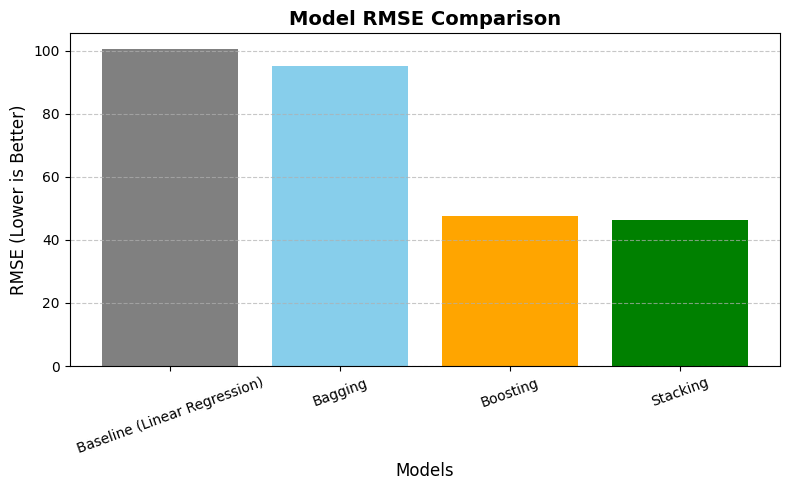

In [25]:

import matplotlib.pyplot as plt

# Model names and RMSE values
models = ['Baseline (Linear Regression)', 'Bagging', 'Boosting', 'Stacking']
rmse_values = [100.4459, 95.0080, 47.7000, 46.3724]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_values, color=['gray', 'skyblue', 'orange', 'green'])
plt.title("Model RMSE Comparison", fontsize=14, fontweight='bold')
plt.ylabel("RMSE (Lower is Better)", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



### 📊 1️⃣ Comparative RMSE Table

| Model | Description | RMSE | Observation |
|:--|:--|--:|:--|
| **Linear Regression** | Baseline single model (best of DT/LR) | **100.4459** | Moderate bias and variance |
| **Decision Tree Regressor** | Simple non-linear model | 118.4555 | Overfits slightly — high variance |
| **Bagging Regressor** | Ensemble of Decision Trees (variance reduction) | 95.0080 | Reduced variance but still limited improvement |
| **Gradient Boosting Regressor** | Sequential boosting (bias reduction) | 47.7000 | Significantly reduced bias, major performance gain |
| **Stacking Regressor** | Combination of KNN, Bagging, and Boosting with Ridge meta-learner | **46.3724** | Best overall generalization |

---

### 2️⃣ Conclusion

- The **Stacking Regressor** achieved the **lowest RMSE (46.3724)**, outperforming all other models.  
- This improvement demonstrates how stacking effectively combines the strengths of multiple ensemble techniques.  

#### **Why Stacking Outperformed the Single Model:**
- **Model Diversity:** Each base learner captures unique relationships in the data — KNN handles local patterns, Bagging reduces variance, and Boosting minimizes bias.  
- **Bias-Variance Trade-off:**  
  - Linear Regression → high bias, low variance.  
  - Bagging → low variance, moderate bias.  
  - Boosting → low bias, slightly higher variance.  
  - Stacking → balances both bias and variance by learning optimal weights for each model’s predictions.  
- The **meta-learner (Ridge Regression)** effectively blends these complementary predictions, leading to **improved stability and predictive accuracy**.

✅ **Final Verdict:**  
> The **Stacking Ensemble** is the best-performing model because it leverages model diversity and optimally manages the bias-variance trade-off, achieving the most accurate and generalized predictions for bike rental demand forecasting.
